# <span> Laboratorio di Simulazione Numerica  </span>
## <span> Esercitazione 5 </span>
### Esercizio 5.1

Lo scopo di questo esercizio è quello di implementare l'algoritmo di <b>Metropolis</b> in modo tale da poter campionare qualsiasi distribuzione di probabilità, anche nel caso in cui non si conosca il fattore di normalizzazione. In particolare, siamo interessati a campionare la probabilità che l'elettrone in un atomo di idrogeno si trovi a distanza $\vec r$ dal centro di massa. In questo esercizio consideriamo le due funzioni d'onda relative allo stato fondamentale $1s$ e ad uno dei tre stati eccitati $2p$, etichettate rispettivamente dai numeri quantici $(n,l,m) = (1,0,0)$ e $(n,l,m) = (2,1,0)$. Le densità di probabilità relative a tali stati in coordinate cartesiane hanno le seguenti espressioni
 
$$ P_1 = |\Psi_{1,0,0}(x^*, y^*, z^*)|^2 = \frac{1}{\pi} e^{-2r^*} $$

$$ P_2 = |\Psi_{2,1,0}(x^*, y^*, z^*)|^2 = \frac{(z^*)^2}{32\pi} e^{-r^*} $$

dove il simbolo $^*$ indica le quantità espresse in unità del raggio di Bohr $a_0=0.0529$ nm.

Inizialmente il campionamento è stato eseguito utilizzando una probabilità di transizione $T(\vec{x}|\vec{y})$ uniforme nel cubo di lato $l$ centrato in $\vec y$. Le posizioni campionate vengono poi utilizzate per stimare $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ e $\left\langle r \right\rangle_{\Psi_{2,1,0}}$, confrontandoli con i valori esatti

$$ \left\langle r^* \right\rangle_{\Psi_{1,0,0}} = \frac{3}{2} \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \left\langle r^* \right\rangle_{\Psi_{2,1,0}} = 5 $$

L'incertezza statistica viene calcolata tramite il metodo del data blocking. Successivamente è stata presa come probabilità di transizione una distribuzione Gaussiana centrata in $\vec y$ con varianza $\sigma^2$, verificando che i risultati ottenuti siano equivalenti a quelli precedenti. Il lato del cubo e la varianza della distribuzione Gaussiana sono parametri liberi che vengono fissati dalla regola empirica del $50\%$.
<br>

Per implementare il codice di questo esercizio si utilizza la programmazione a oggetti di C++. È stata creata la classe  <b>Metropolis</b>, che tra i membri privati presenta: un puntatore alla classe <b>Random</b>, i parametri liberi $l$ e $\sigma$, una variabile intera per valutare il numero di volte in cui la nuova configurazione viene accettata e un vettore che rappresenta la posizione dell'elettrone, modificata ad ogni step dell'algoritmo tramite i metodi <b>Step_Unif</b> e <b>Step_Gauss</b>. Per scrivere un codice che sia il più generale possibile, tra i membri privati è presente anche un puntatore alla classe <b>FunzioneBase</b>, dove si sfrutta l'ereditarietà delle classi, permettendo così la scelta di diverse densità di probabilità. 

Una cosa importante da tenere in considerazione è che il campionamento di una particolare densità di probabilità tramite l'algoritmo di Metropolis avviene solo asintoticamente, quindi prima di cominciare la fase di misura è necessario equilibrare l'algoritmo. In generale la fase di equilibrazione dipende dalla probabilità di transizione scelta, ma anche dal punto di partenza, come vedremo poco più avanti.

Di seguito riportiamo i risultati per la prima densità di probabilità con entrambe le probabilità di transizione e successivamente riportiamo quelli per la seconda densità. Tutti i risultati presentati sono in unità di raggio di Bohr.

#### <b>Orbitale 1s - (1,0,0) </b>

I parametri ottimali delle probabilità di transizione sono:

- <span>$l= 2.42$</span>
- <span>$\sigma = 0.75$</span>

Prima di tutto studiamo quanti step sono necessari all'algoritmo per equilibrarsi in base al punto di partenza: iniziamo prima a campionare a partire dal punto $A=(0.9,0.9,0.9)$, vicino al picco della distribuzione $P_1$, successivamente vediamo cosa succede partendo dal punto $B=(70,70,70)$, a grande distanza dal picco.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina'

In [2]:
step, eq_100_unif = np.loadtxt("5.1/eq_100_unif.out", usecols=(0,1), delimiter=' ', unpack='true')
eq_100_gaus = np.loadtxt("5.1/eq_100_gaus.out", usecols=(1), delimiter=' ', unpack='true')
eq_100_unif_far = np.loadtxt("5.1/eq_100_unif_far.out", usecols=(1), delimiter=' ', unpack='true')
eq_100_gaus_far = np.loadtxt("5.1/eq_100_gaus_far.out", usecols=(1), delimiter=' ', unpack='true')

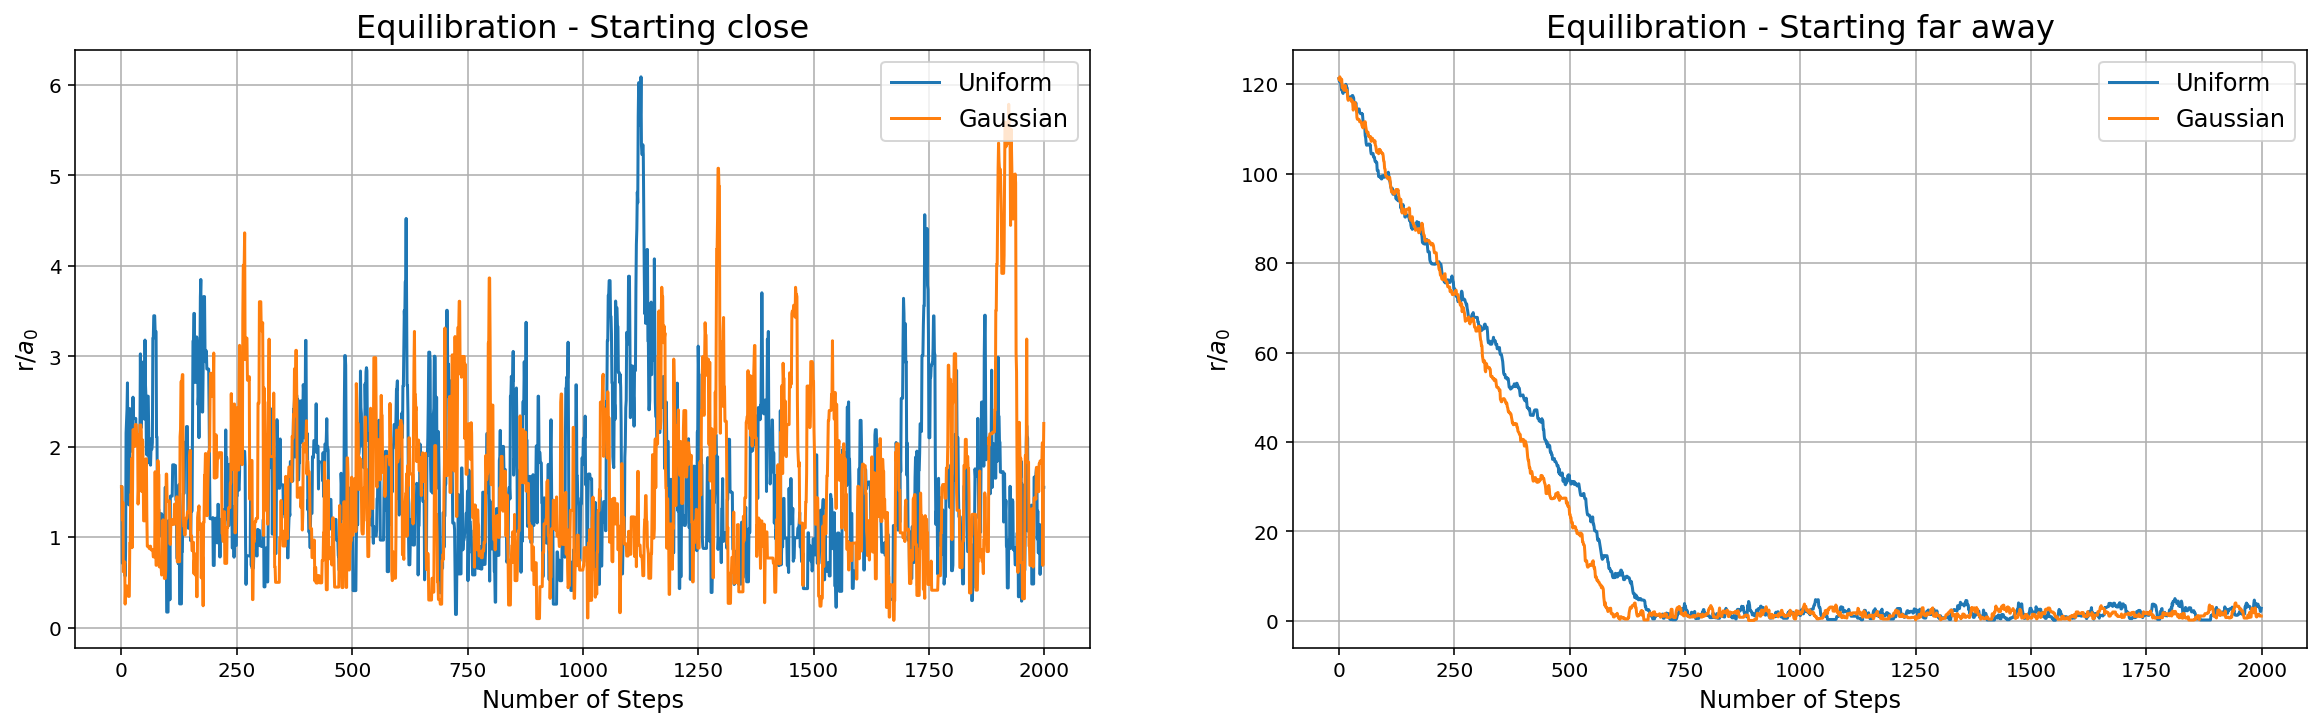

In [3]:
eq_list = [eq_100_unif, eq_100_unif_far, eq_100_gaus, eq_100_gaus_far]
title_list = ['Starting close', 'Starting far away']

fig, ax = plt.subplots(1, 2, figsize=(20, 5.5))
ax = ax.reshape(-1)

for i in range(2):
    ax[i].plot(step[:2000], eq_list[i][:2000], color='tab:blue', label='Uniform')
    ax[i].plot(step[:2000], eq_list[i+2][:2000], color='tab:orange', label='Gaussian')
    ax[i].set_xlabel(r'Number of Steps', fontsize=12)
    ax[i].set_ylabel(r'r$/a_0$', fontsize=12)
    ax[i].set_title(f'Equilibration - {title_list[i]}', fontsize=16)
    ax[i].legend(loc='upper right', fontsize=12)
    ax[i].grid(True)

plt.show()

Quando il sistema parte vicino al picco l'algoritmo inizia fin da subito a campionare punti secondo la distribuzione $P_1$, mentre quando si parte da un punto lontano sono necessari 600 step nel caso Gaussiano e 700 step nel caso uniforme per equilibrare l'algoritmo ed iniziare il campionamento.

Siccome le posizioni generate a ogni step dall'algoritmo di Metropolis sono tra loro correlate, vogliamo determinare il numero di step da effettuare in ogni blocco in modo che le medie di blocco siano tra loro scorrelate. Per fare ciò campionamo $2\cdot 10^5$ posizioni e calcoliamo la funzione di autocorrelazione, definita nel seguente codice di Python 

In [4]:
def ACF(x,tn):
    ac = np.zeros(tn)
    tmax = x.size
    for t in range(tn):
        ac[t] = (np.sum(x[0:tmax-t]*x[t:])/(tmax-t)-(np.sum(x[0:tmax-t])*np.sum(x[t:]))/(tmax-t)**2)/(np.sum(x*x)/tmax-(np.sum(x)/tmax)**2)
    return ac

In [5]:
eq_100_ac_unif = ACF(eq_100_unif,200)
eq_100_ac_gaus = ACF(eq_100_gaus,200)

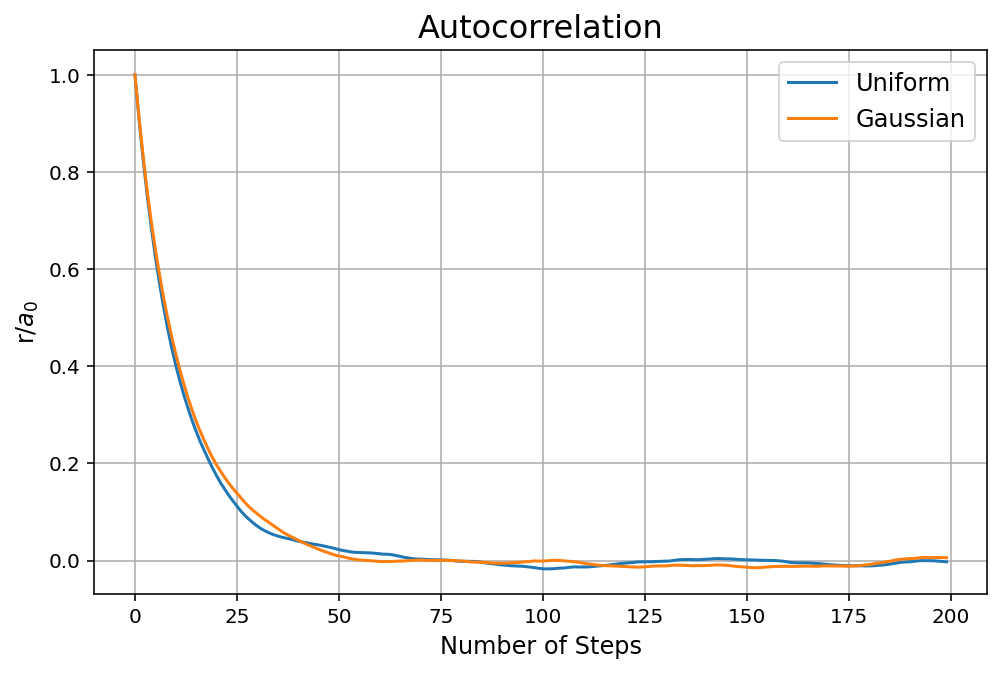

In [6]:
plt.figure(figsize=(8,5))

plt.plot(eq_100_ac_unif, color='tab:blue', label='Uniform')
plt.plot(eq_100_ac_gaus, color='tab:orange', label='Gaussian')
plt.xlabel(r'Number of Steps', fontsize=12)
plt.ylabel(r'r$/a_0$', fontsize=12)
plt.title(f'Autocorrelation', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)

plt.show()

Per entrambe le probabilità di transizione le posizioni risultano correlate per circa 60 step. Per fare in modo che la correlazione tra i blocchi riguardi solo una piccola porzione delle posizioni alla superifice dei blocchi, vengono pressi blocchi di lunghezza pari a $1000$. Viene ora eseguita la stima della distanza media dell'elettrone utilizzando $200$ blocchi. Di seguito viene riportata la differenza tra la distanza media simulata, con la relativa incertezza statistica, e il valore esatto al variare del numero di blocchi.

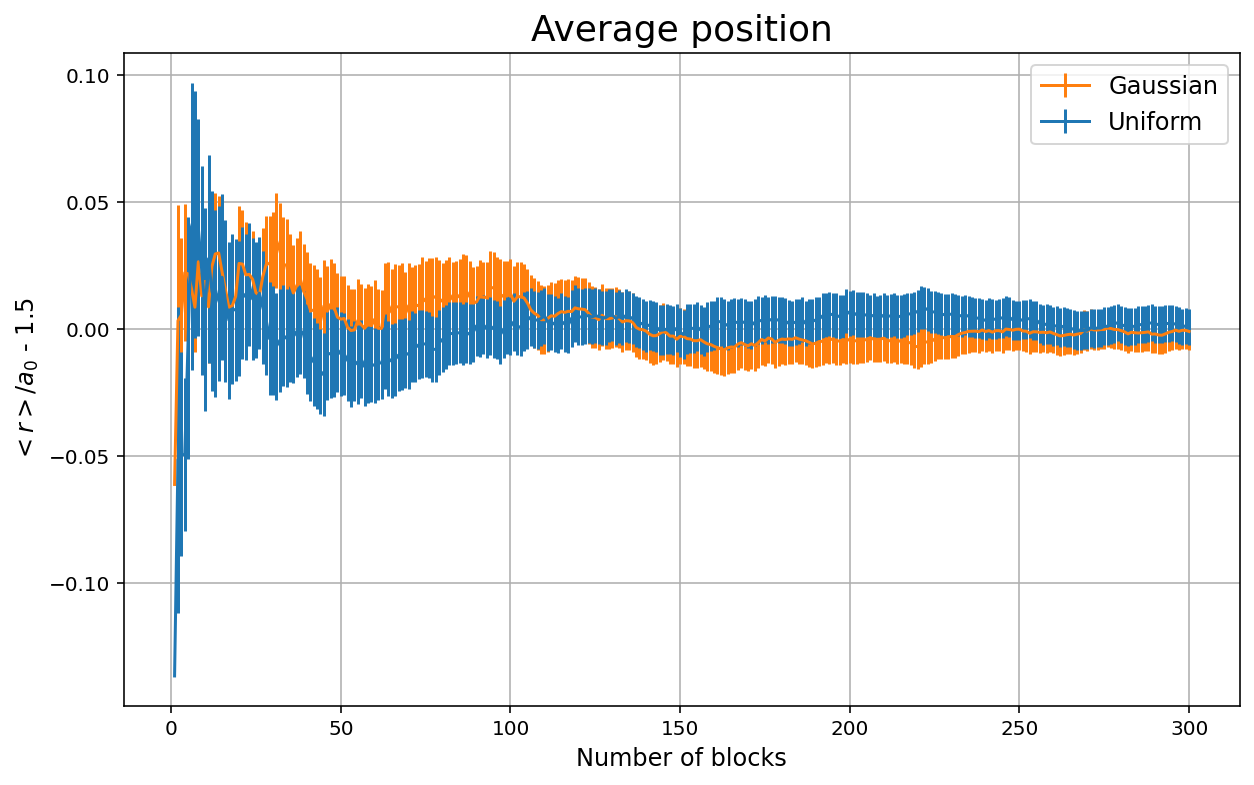

In [7]:
blocks, dist_100_gaus, err_dist_100_gaus = np.loadtxt("5.1/dist_100_gaus.out", usecols=(0,1,2), delimiter=' ', unpack='true')
blocks, dist_100_unif, err_dist_100_unif = np.loadtxt("5.1/dist_100_unif.out", usecols=(0,1,2), delimiter=' ', unpack='true')

plt.figure(figsize=(10,6))
plt.errorbar(blocks, dist_100_gaus-1.5, yerr=err_dist_100_gaus, c='tab:orange', label='Gaussian')
plt.errorbar(blocks, dist_100_unif-1.5, yerr=err_dist_100_unif, c='tab:blue', label='Uniform')
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Number of blocks', fontsize=12)
plt.ylabel(r'$<r>/a_0$ - 1.5', fontsize=12)
plt.title(f'Average position', fontsize=18)
plt.grid(True)
plt.show()

In entrambi i casi all'aumentare del numero di blocchi il valore simulato converge al valore attesso entro l'incertezza statistica.

Infine riportiamo una rappresentazione tridimensionale della distribuzione dei punti estratti tramite l'algoritmo di Metropolis, salvando su file la posizione del punto campionato ogni 10 step.

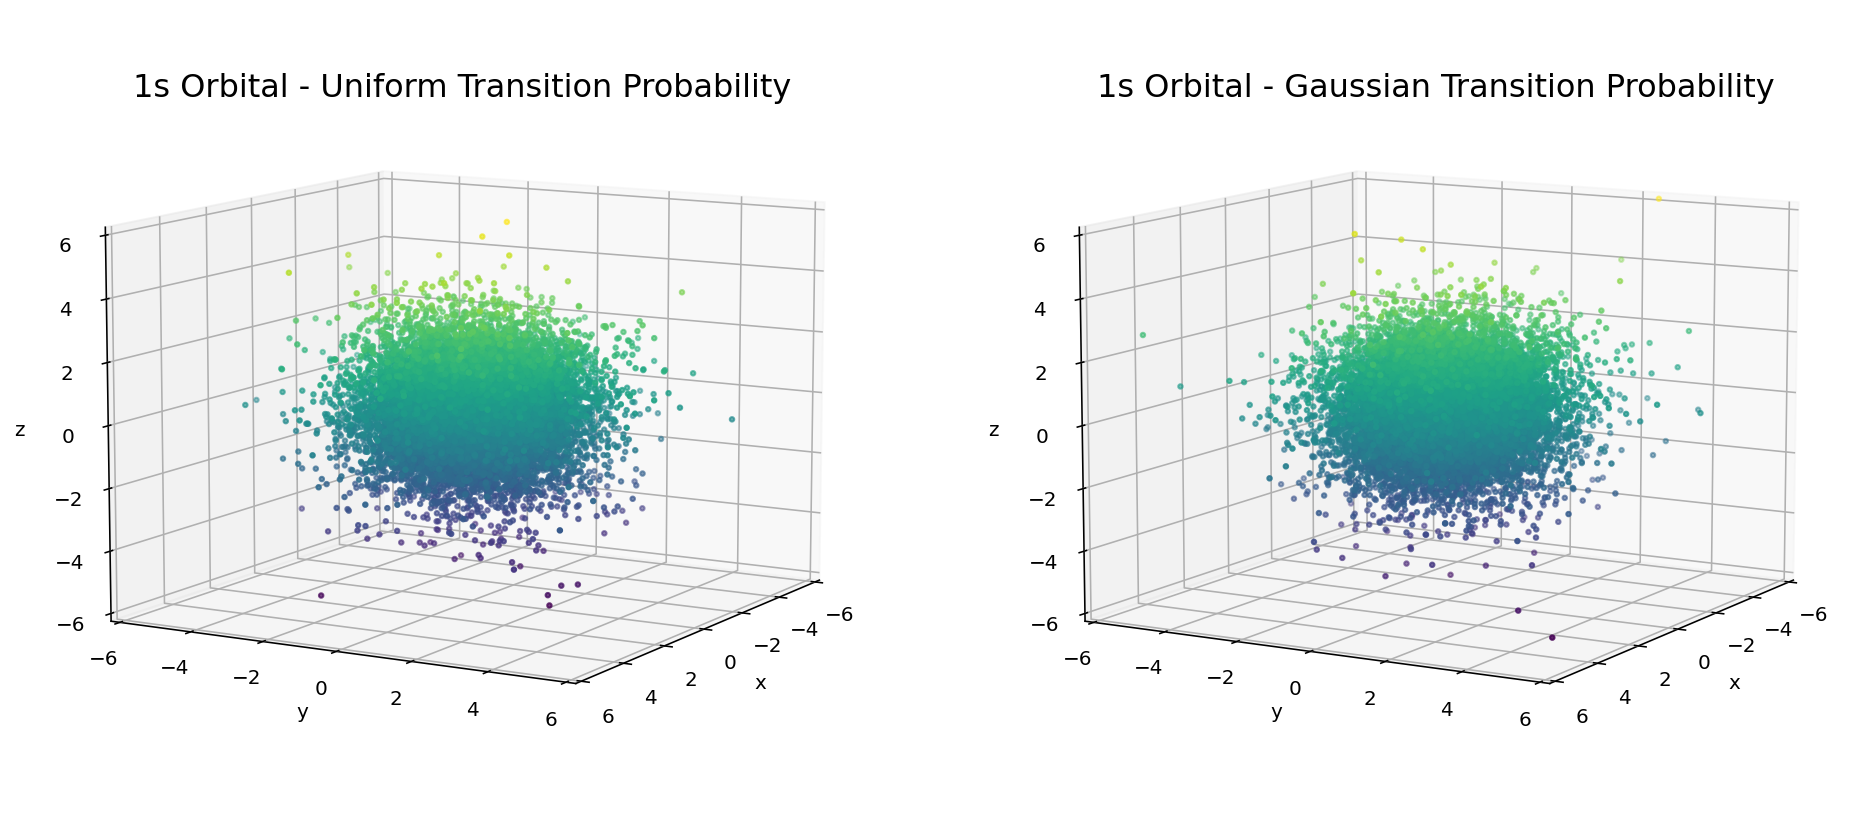

In [8]:
X,Y,Z = np.loadtxt("5.1/pos_100_unif.out", usecols=(0,1,2), delimiter=' ', unpack='true')

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(X, Y, Z, c=Z, marker='.')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_zlim(-6,6)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("1s Orbital - Uniform Transition Probability", fontsize=16, y=0.96)
ax.view_init(10, 30)

X,Y,Z = np.loadtxt("5.1/pos_100_gaus.out", usecols=(0,1,2), delimiter=' ', unpack='true')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(X, Y, Z, c=Z, marker='.')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_zlim(-6,6)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('1s Orbital - Gaussian Transition Probability', fontsize=16, y=0.96)
ax.view_init(10, 30)
plt.show()

Non si notano differenze tra il caso uniforme e quello Gaussiano: il campionamento è efficace con entrambe le probabilità di transizione.

#### <b>Orbitale 2p - (2,1,0) </b>

I parametri ottimali delle probabilità di transizione sono:

- <span>$l= 5.8$</span>
- <span>$\sigma = 1.9$</span>

In questo caso valgono tutte le considerazioni fatte per la precedente densità di probabilità. L'unica differenza è nei punti scelti per l'equilibrazione: come punto vicino si sceglie $A=(2.8,2.8,2.8)$, mentre come punto lontanto si sceglie $B=(90,90,90)$.

In [9]:
step, eq_210_unif = np.loadtxt("5.1/eq_210_unif.out", usecols=(0,1), delimiter=' ', unpack='true')
eq_210_gaus = np.loadtxt("5.1/eq_210_gaus.out", usecols=(1), delimiter=' ', unpack='true')
eq_210_unif_far = np.loadtxt("5.1/eq_210_unif_far.out", usecols=(1), delimiter=' ', unpack='true')
eq_210_gaus_far = np.loadtxt("5.1/eq_210_gaus_far.out", usecols=(1), delimiter=' ', unpack='true')

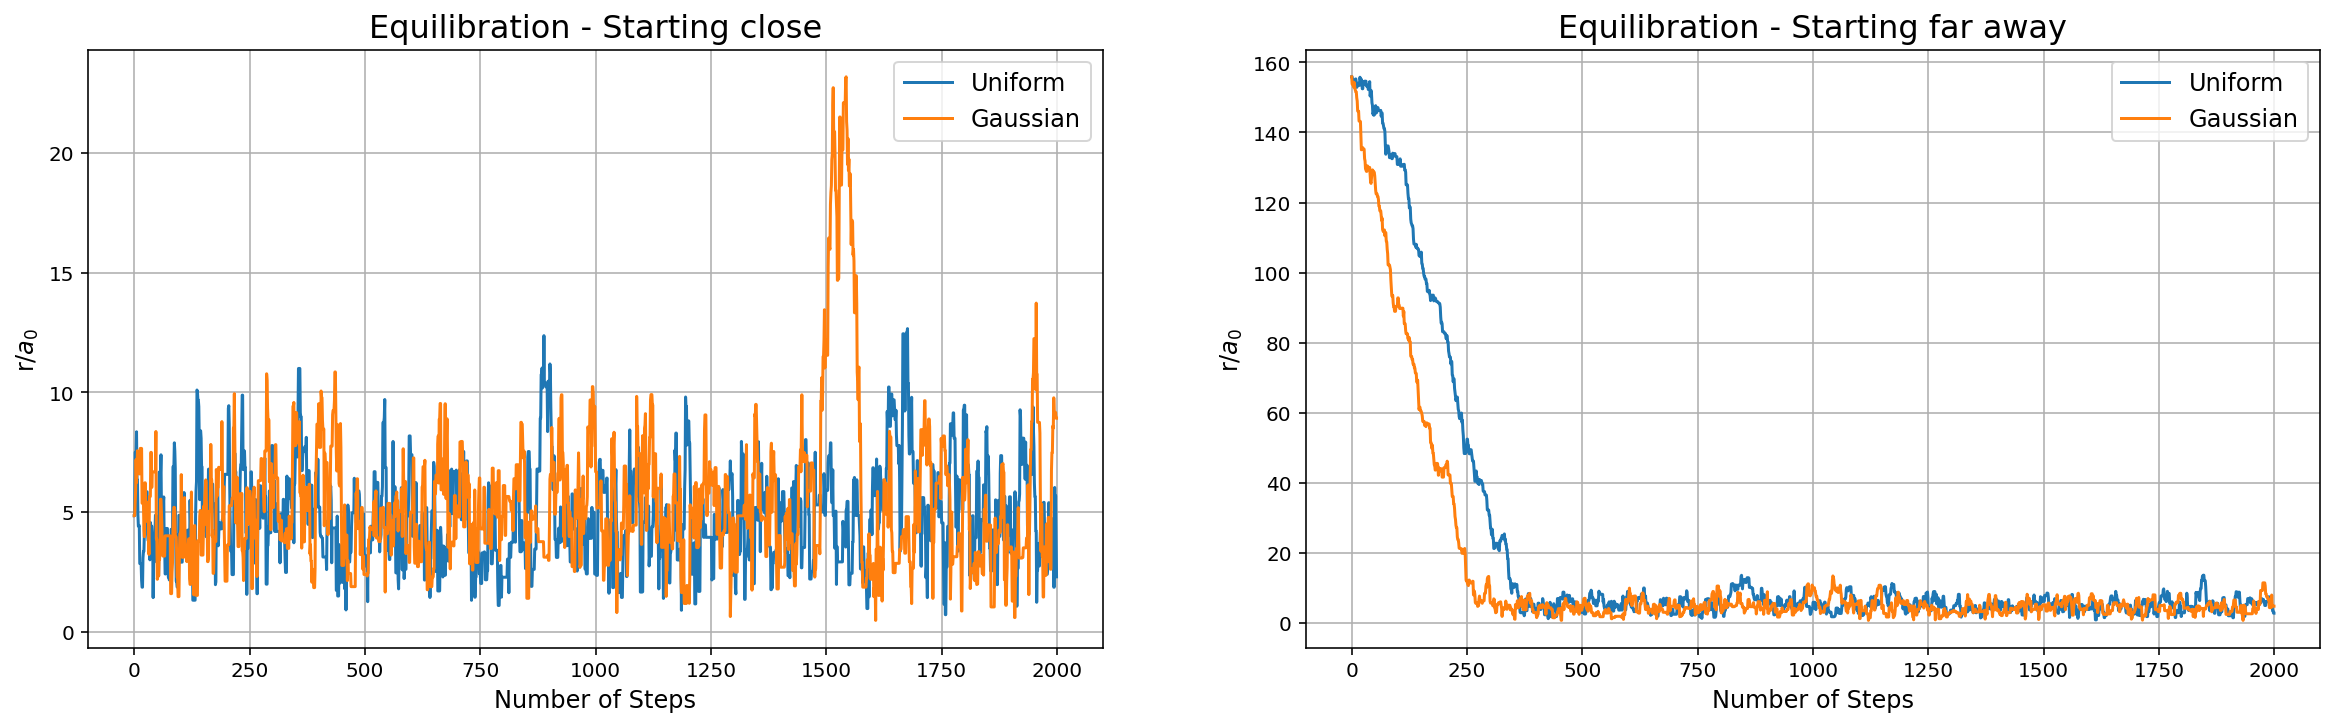

In [10]:
eq_list = [eq_210_unif, eq_210_unif_far, eq_210_gaus, eq_210_gaus_far]
title_list = ['Starting close', 'Starting far away']

fig, ax = plt.subplots(1, 2, figsize=(20, 5.5))
ax = ax.reshape(-1)

for i in range(2):
    ax[i].plot(step[:2000], eq_list[i][:2000], color='tab:blue', label='Uniform')
    ax[i].plot(step[:2000], eq_list[i+2][:2000], color='tab:orange', label='Gaussian')
    ax[i].set_xlabel(r'Number of Steps', fontsize=12)
    ax[i].set_ylabel(r'r$/a_0$', fontsize=12)
    ax[i].set_title(f'Equilibration - {title_list[i]}', fontsize=16)
    ax[i].legend(loc='upper right', fontsize=12)
    ax[i].grid(True)

plt.show()

In [11]:
eq_210_ac_unif = ACF(eq_210_unif,200)
eq_210_ac_gaus = ACF(eq_210_gaus,200)

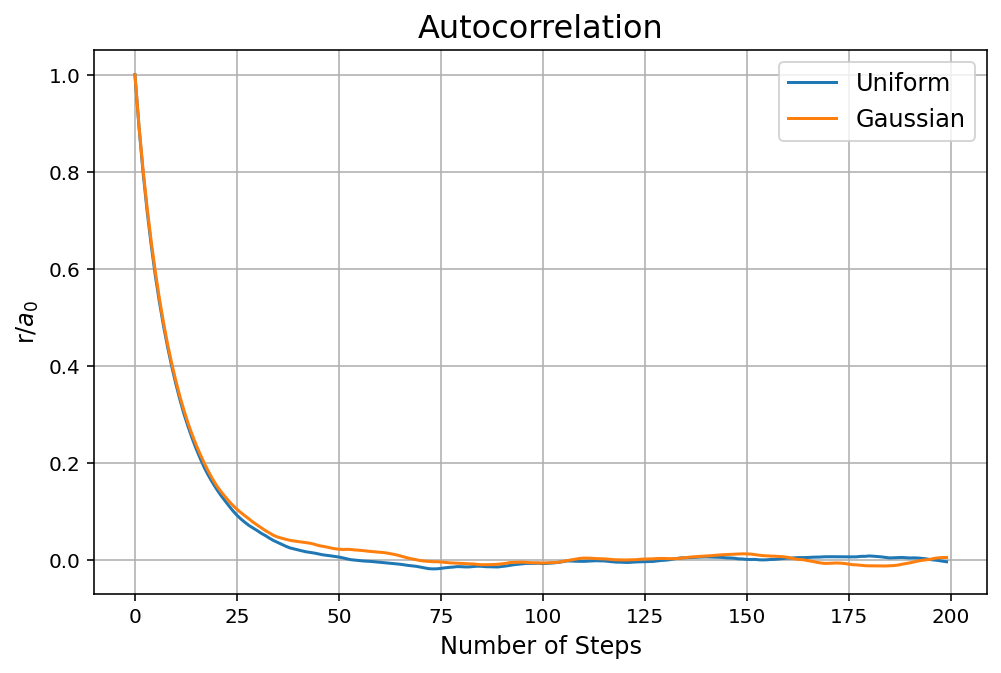

In [12]:
plt.figure(figsize=(8,5))

plt.plot(eq_210_ac_unif, color='tab:blue', label='Uniform')
plt.plot(eq_210_ac_gaus, color='tab:orange', label='Gaussian')
plt.xlabel(r'Number of Steps', fontsize=12)
plt.ylabel(r'r$/a_0$', fontsize=12)
plt.title(f'Autocorrelation', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)

plt.show()

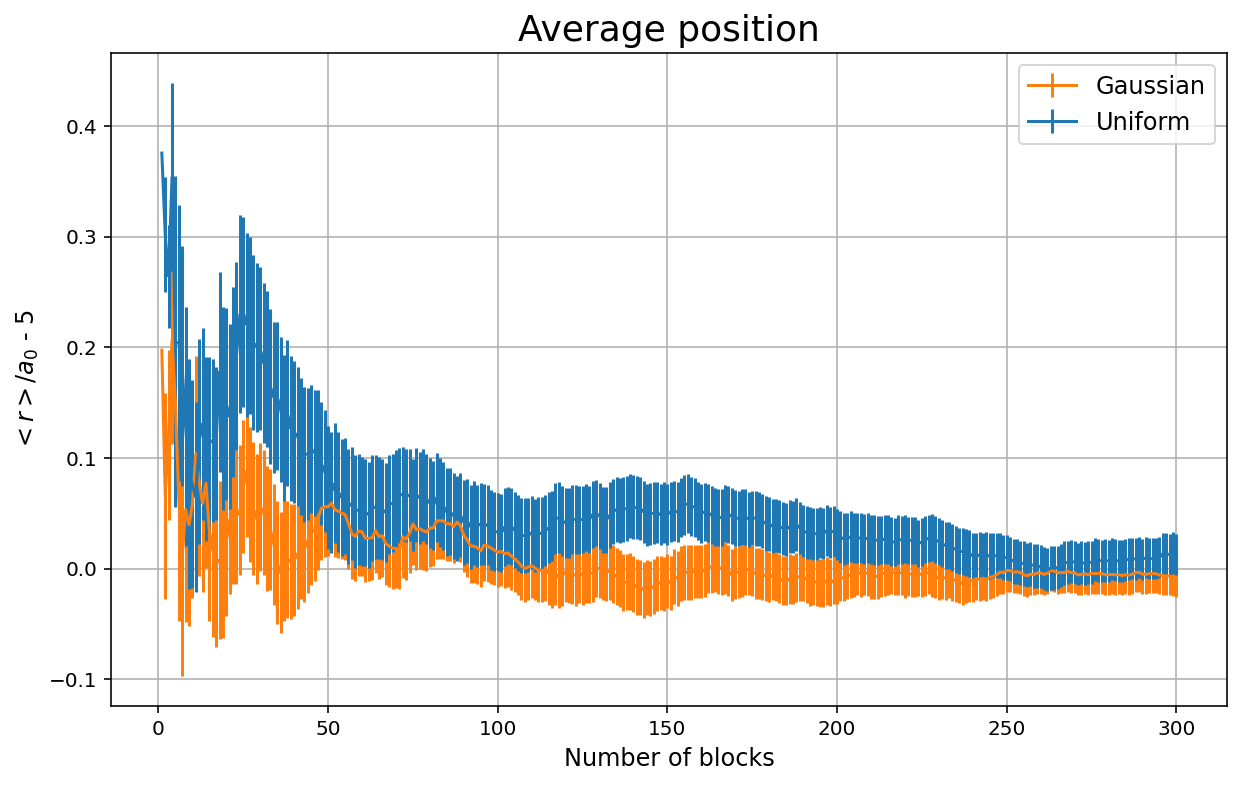

In [13]:
blocks, dist_210_gaus, err_dist_210_gaus = np.loadtxt("5.1/dist_210_gaus.out", usecols=(0,1,2), delimiter=' ', unpack='true')
blocks, dist_210_unif, err_dist_210_unif = np.loadtxt("5.1/dist_210_unif.out", usecols=(0,1,2), delimiter=' ', unpack='true')

plt.figure(figsize=(10,6))
plt.errorbar(blocks, dist_210_gaus-5, yerr=err_dist_210_gaus, c='tab:orange', label='Gaussian')
plt.errorbar(blocks, dist_210_unif-5, yerr=err_dist_210_unif, c='tab:blue', label='Uniform')
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Number of blocks', fontsize=12)
plt.ylabel(r'$<r>/a_0$ - 5', fontsize=12)
plt.title(f'Average position', fontsize=18)
plt.grid(True)
plt.show()

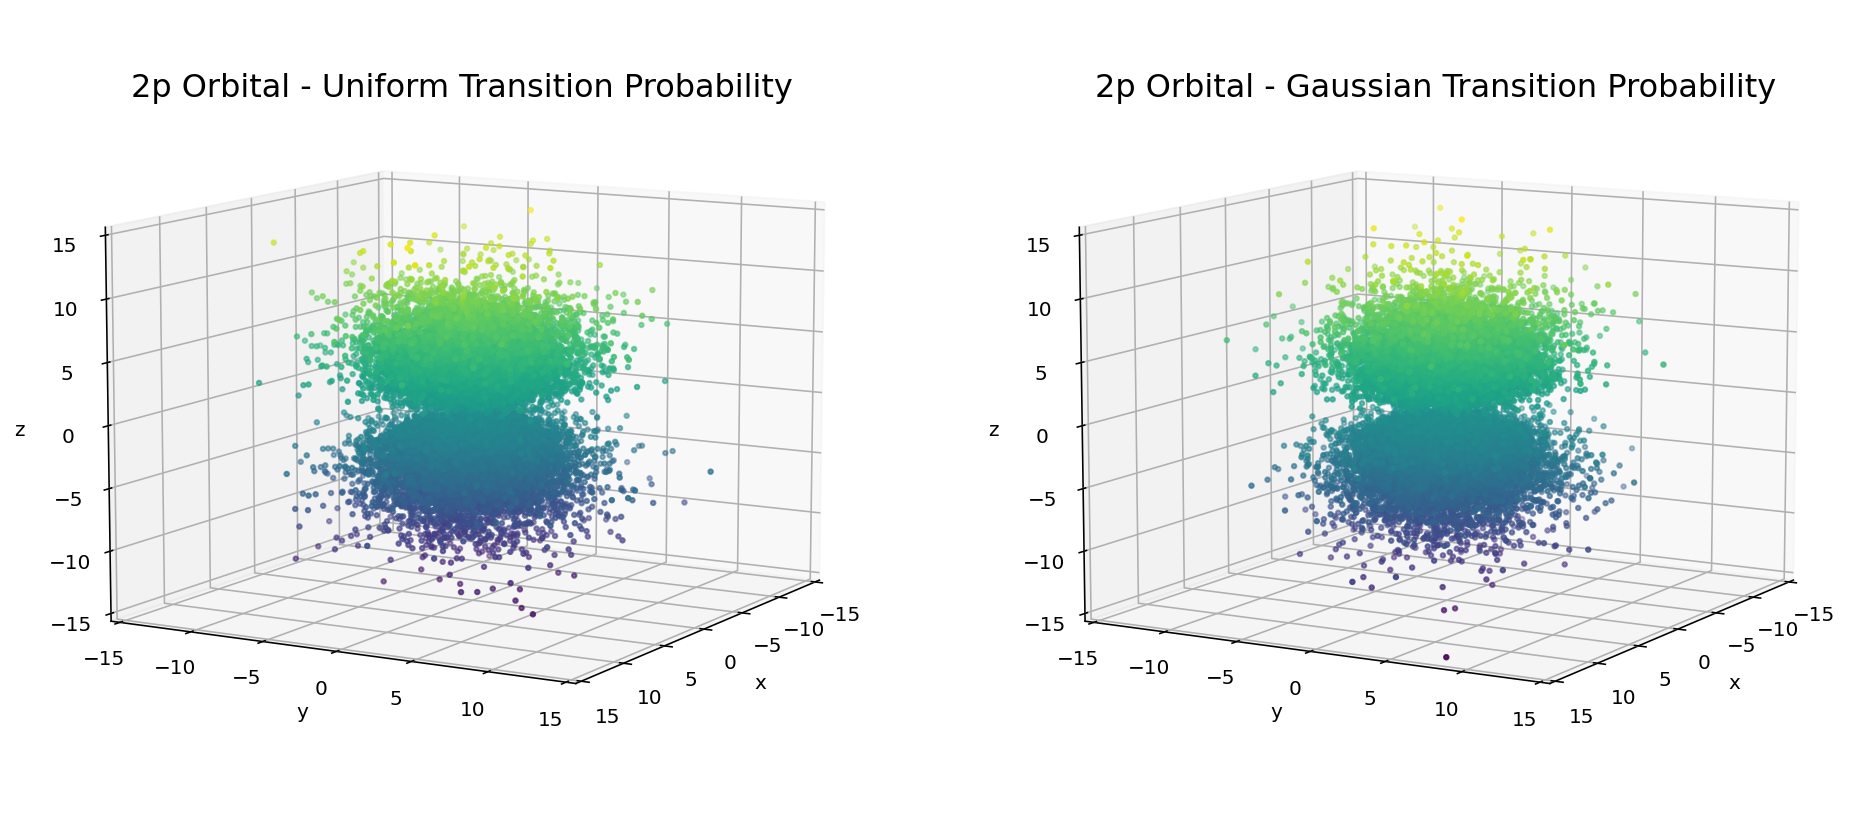

In [14]:
X,Y,Z = np.loadtxt("5.1/pos_210_unif.out", usecols=(0,1,2), delimiter=' ', unpack='true')

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(X, Y, Z, c=Z, marker='.')
ax.set_xlim(-15,15)
ax.set_ylim(-15,15)
ax.set_zlim(-15,15)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("2p Orbital - Uniform Transition Probability", fontsize=16, y=0.96)
ax.view_init(10, 30)

X,Y,Z = np.loadtxt("5.1/pos_210_gaus.out", usecols=(0,1,2), delimiter=' ', unpack='true')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(X, Y, Z, c=Z, marker='.')
ax.set_xlim(-15,15)
ax.set_ylim(-15,15)
ax.set_zlim(-15,15)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('2p Orbital - Gaussian Transition Probability', fontsize=16, y=0.96)
ax.view_init(10, 30)
plt.show()